## 🦠 Malaria Detection using Logistic Regression

### Machine Learning Project – Image Classification

- **Dataset:** Cell Images (Parasitized vs Uninfected)  
- **Model:** Logistic Regression Classifier  
- **Features:** Image Pixels (PCA) + Color Statistics  

---

##  Section 1: Import Libraries

Import all required libraries for image processing, machine learning, and visualization.

In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Section 2: Configuration & Paths Setup

Define dataset paths and preprocessing parameters.

In [2]:
base_path = r"D:\ML Project\cell_images"
parasitized_path = os.path.join(base_path, "Parasitized")
uninfected_path = os.path.join(base_path, "Uninfected")
save_path = r"D:\ML Project\models"

CONFIG = {
    'target_size': (80, 80),
    'use_clahe': True,
    'gamma': 1.4,
    'test_size': 0.15,
    'val_size': 0.15,
    'random_state': 42,
    'n_components_pca': 800
}
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

print(f"Dataset Path: {base_path}")
print(f"Image Size: {CONFIG['target_size']}")
print(f"PCA Components: {CONFIG['n_components_pca']}")

Dataset Path: D:\ML Project\cell_images
Image Size: (80, 80)
PCA Components: 800


##  Section 3: Image Preprocessing Functions

Enhanced preprocessing with CLAHE, Gamma Correction, and Sharpening

In [3]:
def adjust_gamma(image, gamma=1.4):
    """Apply gamma correction to enhance contrast"""
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def enhance_image(img):
    """Apply multiple enhancement techniques:
    1. CLAHE on L channel (LAB color space)
    2. Gamma correction
    3. Sharpening filter
    """
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    
    lab_clahe = cv2.merge([l_clahe, a, b])
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    img_enhanced = adjust_gamma(img_enhanced, CONFIG['gamma'])
    
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)
    img_enhanced = np.clip(img_enhanced, 0, 255).astype('uint8')
    
    return img_enhanced

def extract_color_features(img):
    """Extract color statistics:
    - Mean and Std for each RGB channel (6 features)
    - Color histograms for each channel (96 features)
    Total: 102 color features
    """
    features = []
    
    for i in range(3):
        features.append(np.mean(img[:,:,i]))
        features.append(np.std(img[:,:,i]))
    
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 256])
        features.extend(hist.flatten())
    
    return np.array(features)

print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


## Section 4: Load and Process Images

Load images from both classes and apply preprocessing

In [6]:
parasitized_path = "./cell_images/Parasitized"
uninfected_path = "./cell_images/Uninfected"


In [7]:
def load_images_enhanced(folder_path, label):
    """Load images from folder and extract features"""
    images, labels, color_features = [], [], []
    
    for root, dirs, files in os.walk(folder_path):
        for filename in tqdm(files, desc=f" {os.path.basename(folder_path)}"):
            if not filename.lower().endswith(valid_extensions):
                continue
            
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            img = cv2.resize(img, CONFIG['target_size'], interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img = enhance_image(img)
            
            color_feat = extract_color_features(img)
            color_features.append(color_feat)
            
            img = img.astype('float32') / 255.0
            
            images.append(img)
            labels.append(label)
    
    return images, labels, color_features

print("Loading and processing images...")
print("-" * 60)

parasitized_images, parasitized_labels, parasitized_colors = load_images_enhanced(
    parasitized_path, 1
)
uninfected_images, uninfected_labels, uninfected_colors = load_images_enhanced(
    uninfected_path, 0
)

images = parasitized_images + uninfected_images
labels = parasitized_labels + uninfected_labels
color_features = parasitized_colors + uninfected_colors

print(f"\n✅ Total Images Loaded: {len(images)}")
print(f"Parasitized: {len(parasitized_images)}")
print(f"Uninfected: {len(uninfected_images)}")

del parasitized_images, uninfected_images, parasitized_labels, uninfected_labels
del parasitized_colors, uninfected_colors
gc.collect()

Loading and processing images...
------------------------------------------------------------


 Parasitized:   0%|          | 0/13780 [00:00<?, ?it/s]

 Uninfected: 100%|██████████| 13780/13780 [00:55<00:00, 248.44it/s]


✅ Total Images Loaded: 27558
Parasitized: 13779
Uninfected: 13779


1160

## Section 5: Feature Matrix Creation

Flatten images and combine with color features

In [8]:
print("Creating feature matrix...")
n_samples = len(images)
n_features = images[0].flatten().shape[0]

X_image = np.empty((n_samples, n_features), dtype='float32')
y = np.array(labels)

for i in tqdm(range(n_samples), desc="Flattening images"):
    X_image[i] = images[i].flatten()

X_color = np.array(color_features, dtype='float32')

print(f"\n Feature Matrix Created:")
print(f"Image Features: {X_image.shape}")
print(f"Color Features: {X_color.shape}")

del images, labels, color_features
gc.collect()

Creating feature matrix...


Flattening images: 100%|██████████| 27558/27558 [00:01<00:00, 22486.86it/s]



 Feature Matrix Created:
Image Features: (27558, 19200)
Color Features: (27558, 102)


9

## Section 6: Train/Validation/Test Split

Split data into training (70%), validation (15%), and test (15%) sets

In [9]:
print("Splitting data into Train/Val/Test...")

# First split: separate test set
X_image_temp, X_image_test, X_color_temp, X_color_test, y_temp, y_test = train_test_split(
    X_image, X_color, y,
    test_size=CONFIG['test_size'],
    stratify=y,
    random_state=CONFIG['random_state']
)

# Second split: separate train and validation
val_size_adjusted = CONFIG['val_size'] / (1 - CONFIG['test_size'])
X_image_train, X_image_val, X_color_train, X_color_val, y_train, y_val = train_test_split(
    X_image_temp, X_color_temp, y_temp,
    test_size=val_size_adjusted,
    stratify=y_temp,
    random_state=CONFIG['random_state']
)

print(f"\nData Split Complete:")
print(f"Training Set:   {len(y_train)} samples ({len(y_train)/len(y)*100:.1f}%)")
print(f"Validation Set: {len(y_val)} samples ({len(y_val)/len(y)*100:.1f}%)")
print(f"Test Set:       {len(y_test)} samples ({len(y_test)/len(y)*100:.1f}%)")

del X_image, X_color, y, X_image_temp, X_color_temp, y_temp
gc.collect()

Splitting data into Train/Val/Test...

Data Split Complete:
Training Set:   19290 samples (70.0%)
Validation Set: 4134 samples (15.0%)
Test Set:       4134 samples (15.0%)


0

## Section 7: Feature Standardization

Standardize features to have zero mean and unit variance

In [10]:
print("Standardizing features...")

scaler_image = StandardScaler()
X_image_train = scaler_image.fit_transform(X_image_train)
X_image_val = scaler_image.transform(X_image_val)
X_image_test = scaler_image.transform(X_image_test)

scaler_color = StandardScaler()
X_color_train = scaler_color.fit_transform(X_color_train)
X_color_val = scaler_color.transform(X_color_val)
X_color_test = scaler_color.transform(X_color_test)

print("✅ Standardization complete!")

Standardizing features...
✅ Standardization complete!


## Section 8: Dimensionality Reduction using PCA

Apply PCA to reduce image features from 19,200 to 800 dimensions

In [11]:
print("Applying PCA for dimensionality reduction...")

pca = PCA(n_components=CONFIG['n_components_pca'], random_state=CONFIG['random_state'])
X_image_train_pca = pca.fit_transform(X_image_train)
X_image_val_pca = pca.transform(X_image_val)
X_image_test_pca = pca.transform(X_image_test)

variance_explained = pca.explained_variance_ratio_.sum() * 100
print(f"PCA Complete - Variance Explained: {variance_explained:.2f}%")

X_train = np.hstack([X_image_train_pca, X_color_train])
X_val = np.hstack([X_image_val_pca, X_color_val])
X_test = np.hstack([X_image_test_pca, X_color_test])

print(f"\n Final Feature Dimensions:")
print(f"   Training:   {X_train.shape}")
print(f"   Validation: {X_val.shape}")
print(f"   Test:       {X_test.shape}")

del X_image_train, X_image_val, X_image_test
del X_image_train_pca, X_image_val_pca, X_image_test_pca
del X_color_train, X_color_val, X_color_test
gc.collect()

Applying PCA for dimensionality reduction...
PCA Complete - Variance Explained: 76.09%

 Final Feature Dimensions:
   Training:   (19290, 902)
   Validation: (4134, 902)
   Test:       (4134, 902)


0

## Section 9: Train Logistic Regression Model

Train with iterative learning to track loss curve

In [12]:
print("="*70)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

max_iter_per_step = 100
n_steps = 20

log_reg = LogisticRegression(
    C=1.0,
    max_iter=max_iter_per_step,
    solver='saga',
    penalty='l2',
    warm_start=True,
    random_state=42,
    verbose=0,
    tol=1e-4
)

print("\nTraining in progress...")
print(f"Configuration: {n_steps} steps × {max_iter_per_step} iterations = {n_steps * max_iter_per_step} total")

from sklearn.metrics import log_loss

for step in tqdm(range(n_steps), desc="Training"):
    log_reg.fit(X_train, y_train)
    
    y_train_pred_proba = log_reg.predict_proba(X_train)
    y_val_pred_proba = log_reg.predict_proba(X_val)
    
    train_loss = log_loss(y_train, y_train_pred_proba)
    val_loss = log_loss(y_val, y_val_pred_proba)
    
    train_acc = accuracy_score(y_train, log_reg.predict(X_train))
    val_acc = accuracy_score(y_val, log_reg.predict(X_val))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

print("\n✅ Training Complete!")


Training in progress...
Configuration: 20 steps × 100 iterations = 2000 total


Training:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training:   5%|▌         | 1/20 [00:22<07:05, 22.38s/it]c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training:  10%|█         | 2/20 [00:44<06:38, 22.16s/it]c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training:  15%|█▌        | 3/20 [01:06<06:14, 22.02s/it]c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training:  20%|██        | 4/20 [01:28<05:50, 21.92s/it]c:\Users\DELL\anacon


✅ Training Complete!


## Section 10: Plot Training Loss Curve

Visualize training and validation loss over iterations

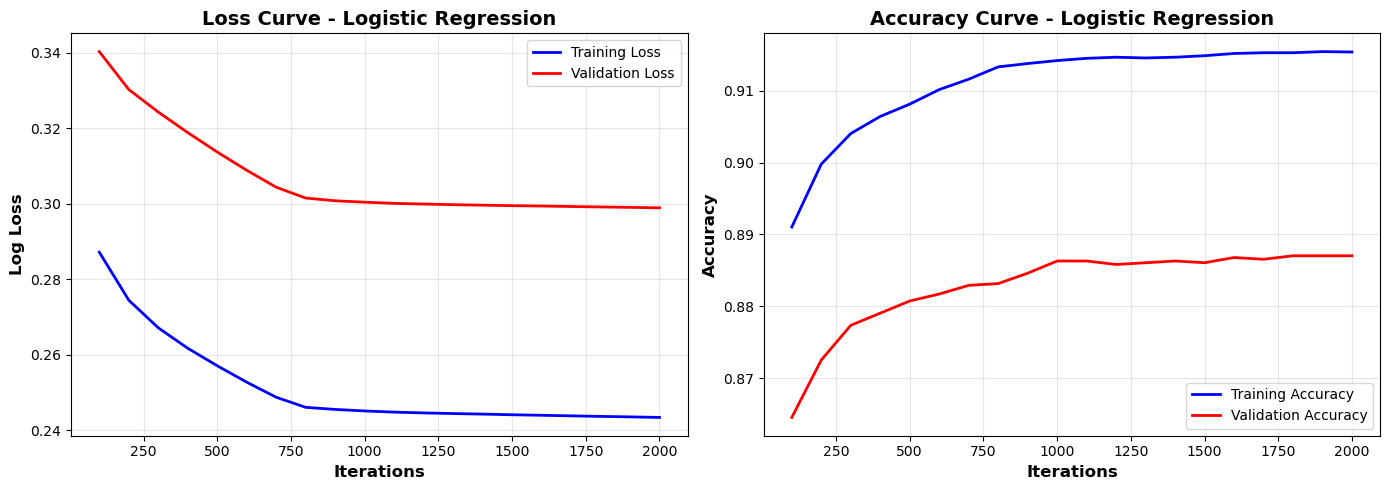

Final Training Loss: 0.2434
Final Validation Loss: 0.2989
Final Training Accuracy: 91.54%
Final Validation Accuracy: 88.70%


In [14]:
import os

# المسار الجديد
save_path = r"D:\ThirdYearAI\Machine learning\project\MLprojectsUni-main"

# تأكد أن المجلد موجود
os.makedirs(save_path, exist_ok=True)

# رسم وحفظ المنحنيات
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
iterations = np.arange(1, len(train_losses) + 1) * max_iter_per_step
plt.plot(iterations, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(iterations, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Iterations', fontsize=12, fontweight='bold')
plt.ylabel('Log Loss', fontsize=12, fontweight='bold')
plt.title('Loss Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(iterations, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(iterations, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Iterations', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Accuracy Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'loss_accuracy_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")


## Section 11: Model Evaluation on Test Set

Calculate accuracy, ROC-AUC, and generate classification report

In [15]:
print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\n Test Accuracy: {accuracy*100:.2f}%")
print(f" Test ROC-AUC:  {roc_auc:.4f}")

print("\n Classification Report:")
print("-" * 70)
print(classification_report(y_test, y_pred, target_names=['Uninfected (Class 0)', 'Parasitized (Class 1)'],digits=4))


MODEL EVALUATION ON TEST SET

 Test Accuracy: 89.24%
 Test ROC-AUC:  0.9536

 Classification Report:
----------------------------------------------------------------------
                       precision    recall  f1-score   support

 Uninfected (Class 0)     0.8683    0.9250    0.8958      2067
Parasitized (Class 1)     0.9198    0.8597    0.8887      2067

             accuracy                         0.8924      4134
            macro avg     0.8940    0.8924    0.8922      4134
         weighted avg     0.8940    0.8924    0.8922      4134



## Section 12: Confusion Matrix Visualization

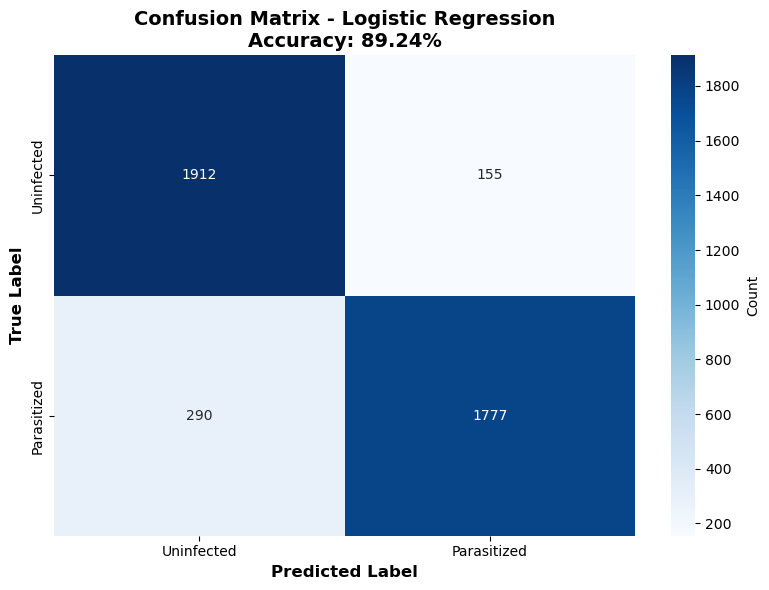


 Detailed Metrics:
   Sensitivity (Recall): 85.97%
   Specificity:          92.50%
   Precision:            91.98%


In [16]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'],yticklabels=['Uninfected', 'Parasitized'],cbar_kws={'label': 'Count'})

plt.title(f"Confusion Matrix - Logistic Regression\nAccuracy: {accuracy*100:.2f}%",fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

print(f"\n Detailed Metrics:")
print(f"   Sensitivity (Recall): {sensitivity*100:.2f}%")
print(f"   Specificity:          {specificity*100:.2f}%")
print(f"   Precision:            {precision*100:.2f}%")

## Section 13: ROC Curve Visualization

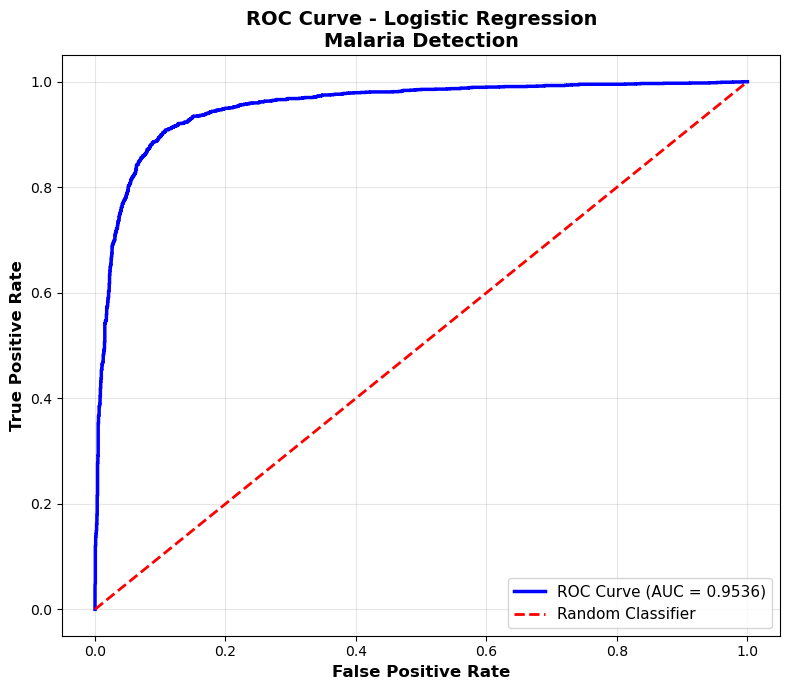

✅ ROC Curve plotted with AUC = 0.9536


In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, 'b-', linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Logistic Regression\nMalaria Detection', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ ROC Curve plotted with AUC = {roc_auc:.4f}")

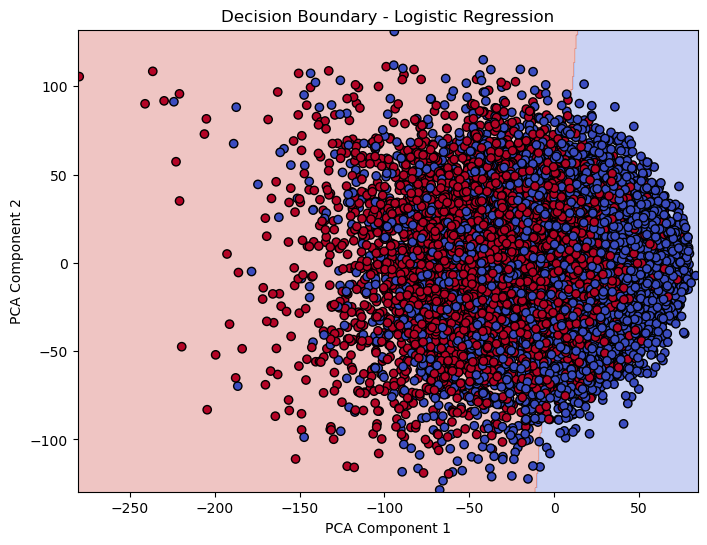

In [18]:
# Use first 2 PCA components for visualization
X_vis = X_train[:, :2]
y_vis = y_train

# Train logistic regression on 2D features
from sklearn.linear_model import LogisticRegression

log_reg_2d = LogisticRegression()
log_reg_2d.fit(X_vis, y_vis)

# Plot decision boundary
import matplotlib.pyplot as plt
import numpy as np

x_min, x_max = X_vis[:,0].min() - 1, X_vis[:,0].max() + 1
y_min, y_max = X_vis[:,1].min() - 1, X_vis[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = log_reg_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, edgecolor='k', cmap='coolwarm')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary - Logistic Regression')
plt.show()


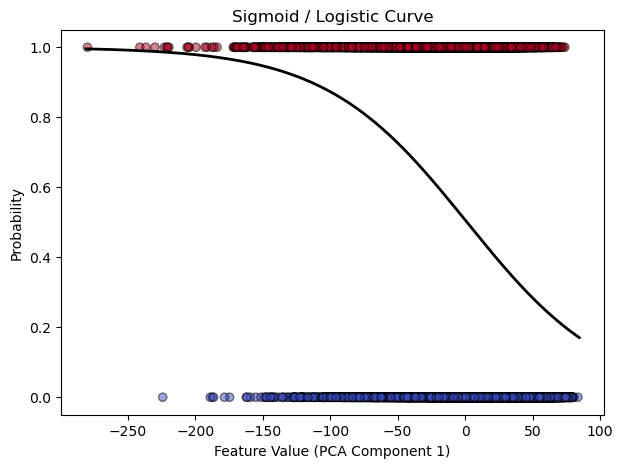

In [19]:
# Pick one feature, e.g., first PCA component
X_feat = X_train[:, 0].reshape(-1,1)
y_feat = y_train

from sklearn.linear_model import LogisticRegression
log_reg_feat = LogisticRegression()
log_reg_feat.fit(X_feat, y_feat)

# Sigmoid curve
x_plot = np.linspace(X_feat.min()-1, X_feat.max()+1, 500).reshape(-1,1)
y_prob = log_reg_feat.predict_proba(x_plot)[:,1]

plt.figure(figsize=(7,5))
plt.scatter(X_feat, y_feat, c=y_feat, cmap='coolwarm', edgecolor='k', alpha=0.5)
plt.plot(x_plot, y_prob, color='black', linewidth=2)
plt.xlabel('Feature Value (PCA Component 1)')
plt.ylabel('Probability')
plt.title('Sigmoid / Logistic Curve')
plt.show()


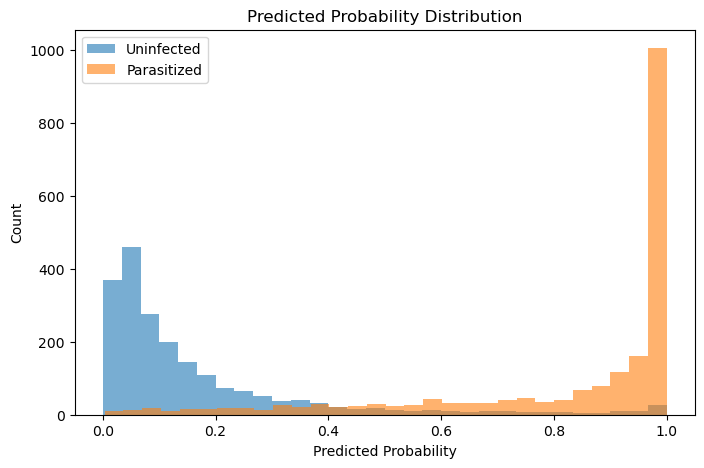

In [20]:
y_prob_test = log_reg.predict_proba(X_test)[:,1]

plt.figure(figsize=(8,5))
plt.hist(y_prob_test[y_test==0], bins=30, alpha=0.6, label='Uninfected')
plt.hist(y_prob_test[y_test==1], bins=30, alpha=0.6, label='Parasitized')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Predicted Probability Distribution')
plt.legend()
plt.show()


## Section 14: Save Model and Preprocessors

In [25]:
print("\n Saving model and preprocessors...")
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, "scaler_image.pkl"), "wb") as f:
    pickle.dump(scaler_image, f)
    
with open(os.path.join(save_path, "scaler_color.pkl"), "wb") as f:
    pickle.dump(scaler_color, f)
    
with open(os.path.join(save_path, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)
    
with open(os.path.join(save_path, "logistic_regression_model.pkl"), "wb") as f:
    pickle.dump(log_reg, f)
    
with open(os.path.join(save_path, "config.pkl"), "wb") as f:
    pickle.dump(CONFIG, f)

training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_accuracy': accuracy,
    'test_roc_auc': roc_auc
}

with open(os.path.join(save_path, "training_history.pkl"), "wb") as f:
    pickle.dump(training_history, f)

print("\n All files saved successfully!")
print(f" Location: {save_path}")
print("\nSaved files:")
print("   • scaler_image.pkl")
print("   • scaler_color.pkl")
print("   • pca.pkl")
print("   • logistic_regression_model.pkl")
print("   • config.pkl")
print("   • training_history.pkl")


 Saving model and preprocessors...

 All files saved successfully!
 Location: D:\ThirdYearAI\Machine learning\project\MLprojectsUni-main

Saved files:
   • scaler_image.pkl
   • scaler_color.pkl
   • pca.pkl
   • logistic_regression_model.pkl
   • config.pkl
   • training_history.pkl


## Section 15: Final Summary Report

In [26]:
print("\n" + "="*70)
print(" FINAL PROJECT SUMMARY")
print("="*70)

print("\n DATASET INFORMATION:")
print(f"   • Dataset Name: Malaria Cell Images")
print(f"   • Number of Classes: 2 (Parasitized, Uninfected)")
print(f"   • Total Samples: {len(y_train) + len(y_val) + len(y_test)}")
print(f"   • Image Size: {CONFIG['target_size']}")
print(f"   • Training Samples: {len(y_train)} ({len(y_train)/(len(y_train)+len(y_val)+len(y_test))*100:.1f}%)")
print(f"   • Validation Samples: {len(y_val)} ({len(y_val)/(len(y_train)+len(y_val)+len(y_test))*100:.1f}%)")
print(f"   • Test Samples: {len(y_test)} ({len(y_test)/(len(y_train)+len(y_val)+len(y_test))*100:.1f}%)")

print("\n FEATURE EXTRACTION:")
print(f"   • Image Features: {n_features} → {CONFIG['n_components_pca']} (after PCA)")
print(f"   • Color Features: 102 (6 statistics + 96 histogram bins)")
print(f"   • Total Features: {X_train.shape[1]}")
print(f"   • PCA Variance Explained: {variance_explained:.2f}%")

print("\n MODEL HYPERPARAMETERS:")
print(f"   • Model: Logistic Regression")
print(f"   • Solver: SAGA")
print(f"   • Regularization: L2 (Ridge)")
print(f"   • C Parameter: 1.0")
print(f"   • Max Iterations: 2000")
print(f"   • Random State: 42")

print("\n RESULTS ON TEST SET:")
print(f"   • Accuracy: {accuracy*100:.2f}%")
print(f"   • ROC-AUC Score: {roc_auc:.4f}")
print(f"   • Sensitivity: {sensitivity*100:.2f}%")
print(f"   • Specificity: {specificity*100:.2f}%")
print(f"   • Precision: {precision*100:.2f}%")

print("\n✅ PROJECT COMPLETE!")
print("="*70)


 FINAL PROJECT SUMMARY

 DATASET INFORMATION:
   • Dataset Name: Malaria Cell Images
   • Number of Classes: 2 (Parasitized, Uninfected)
   • Total Samples: 27558
   • Image Size: (80, 80)
   • Training Samples: 19290 (70.0%)
   • Validation Samples: 4134 (15.0%)
   • Test Samples: 4134 (15.0%)

 FEATURE EXTRACTION:
   • Image Features: 19200 → 800 (after PCA)
   • Color Features: 102 (6 statistics + 96 histogram bins)
   • Total Features: 902
   • PCA Variance Explained: 76.09%

 MODEL HYPERPARAMETERS:
   • Model: Logistic Regression
   • Solver: SAGA
   • Regularization: L2 (Ridge)
   • C Parameter: 1.0
   • Max Iterations: 2000
   • Random State: 42

 RESULTS ON TEST SET:
   • Accuracy: 89.24%
   • ROC-AUC Score: 0.9536
   • Sensitivity: 85.97%
   • Specificity: 92.50%
   • Precision: 91.98%

✅ PROJECT COMPLETE!
